# Semiconductor Production Planning

**Prepared by:** Pauline Wang (pwang7@nd.edu, 2024) and Mariam Jafri (mjafri@nd.edu, 2023)

## Preamble: Install Pyomo and a solver

The following cell sets and verifies a global SOLVER for the notebook. If run on Google Colab, the cell installs Pyomo and the HiGHS solver, while, if run elsewhere, it assumes Pyomo and HiGHS have been previously installed. It then sets to use HiGHS as solver via the appsi module and a test is performed to verify that it is available. The solver interface is stored in a global object `SOLVER` for later use.

In [ ]:
import sys
if "google.colab" in sys.modules:
    !wget "https://raw.githubusercontent.com/ndcbe/optimization/main/notebooks/helper.py"
    import helper
    helper.easy_install()
    helper.install_glpk()
else:
    sys.path.insert(0, '../')
    import helper
helper.set_plotting_style()

--2024-10-08 00:42:28--  https://raw.githubusercontent.com/ndcbe/optimization/main/notebooks/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6493 (6.3K) [text/plain]
Saving to: ‘helper.py.1’

helper.py.1         100%[===================>]   6.34K  --.-KB/s    in 0s      

2024-10-08 00:42:28 (66.7 MB/s) - ‘helper.py.1’ saved [6493/6493]

idaes was found! No need to install.
Installing glpk via apt-get...


In [ ]:
import sys

if 'google.colab' in sys.modules:
    %pip install pyomo >/dev/null 2>/dev/null
    %pip install highspy >/dev/null 2>/dev/null
    #replace this with the import code in our class

solver = 'appsi_highs'

import pyomo.environ as pyo
SOLVER = pyo.SolverFactory(solver)

assert SOLVER.available(), f"Solver {solver} is not available."

import random

import numpy as np
import matplotlib.pyplot as plt

## The microchip production problem

### Problem description
The company BIM (Best International Machines) produces two types of microchips, logic chips (1g silicon, 1g plastic, 4g copper) and memory chips (1g germanium, 1g plastic, 2g copper). Each of the logic chips can be sold for a 12€ profit, and each of the memory chips for a 9€ profit. The current stock of raw materials.





### Building the optimization problem
Let $x \geq 0$ denote the number of logic chips to be produced and $y \geq 0$ the number of memory chips. In the problem described above, the goal is to maximize the total profit. Since for each logic chip the profit is 12 euro, and for each memory chip it is 9 euro, the total profit to maximize is equal to

$$
    12x + 9y.
$$

In maximizing this quantity, we have to respect some constraints. We know that we cannot use more raw materials than those are available in stock.

For copper, this means that the joint usage for logic chips, which is equal to $4x$ g (4g per chip for each of the $x$ chips), and for memory chips, which is equal to $2y$ g (2g per chip for each of the $y$ chips), cannot exceed the maximum availability of 4800g of copper:

$$
    4x + 2y \leq 4800.
$$

Similarly, we can deduce the condition for silicon, which involves only logic chips (note that memory chips do not require this element),

$$
    x \leq 1000,
$$

the condition for germanium, which involves only memory chips (note that logic chips do not require this element),

$$
    y \leq 1500,
$$

and the condition for plastic, which involves both types of chips,

$$
    x + y \leq 1750.
$$


This decision can be reformulated as an optimization problem of the following form:

$$
\begin{align*}
\max \quad & 12x + 9y \\
\text{s.t.} \quad & x \leq 1000 \quad \text{(silicon)} \\
                 & y \leq 1500 \quad \text{(germanium)} \\
                 & x + y \leq 1750 \quad \text{(plastic)} \\
                 & 4x + 2y \leq 4800 \quad \text{(copper)} \\
                 & x, y \geq 0 \\
\end{align*}
$$


Leveraging the fact that we have a two-dimensional problem, we can then visualize the entire feasible region.

![Visualizing Constraints](https://raw.githubusercontent.com/ndcbe/optimization/main/media/contrib/semiconductor_constraints.jpeg)

The feasible region is displayed in gray, enclosed by the linear constraints (solid lines). The isolines corresponding to the objective function are displayed as parallel dashed blue lines with increasing color intensity when the objective function value is larger. We can intuitively already guess the optimal solution, which is marked with a red dot.

### Matrix reformulation of the BIM problem

This problem is relatively small, featuring only $n=2$ decision variables and $m=4$ constraints. Therefore, we decided to add additional three constraints: environmental cost constraint, buyer demand constraint, and quality control constraint. The environmental cost constraint stipulates that each chip produced incurs an environmental cost. Therefore, the total environmental cost, defined as the product of the number of chips and the cost per chip, must not exceed a predetermined maximum. The buyer demand constraint operates as a binary system: a binary value of 0 indicates market preference for logic chips, whereas a binary value of 1 indicates market preference for memory chips. When the parameter alpha equals 0, the optimization will prioritize the production of logic chips; conversely, when alpha equals 1, the optimization will prioritize memory chip production. The quality constraint in this optimization problem assumes that at least 80% of the total manufactured chips are functional and usable, thereby limiting the proportion of defective units to a maximum of 20%. In this project, we aim to determine the optimal number of microchips of each type that should be produced to maximize profit, while respecting the constraints of raw material availability, enviornmental cost, buyer demand, and quality control.

The environmental cost constraint is:

$$
\alpha \cdot (C_{\text{logic}} \cdot x + C_{\text{memory}} \cdot y) \leq E_{\text{max}}
$$


Where:
- $\alpha$ is a binary parameter indicating market preference.
- $C_{\text{logic}}$  and $C_{\text{memory}}$ are the environmental costs per logic and memory chip, respectively.
- $E_{\text{max}}$ is the maximum allowed total environmental cost.



The buyer demand constraint operates as a binary system:

$$
\alpha \in \{0, 1\}
$$

Where:
- $\alpha$ = 0 indicates a market preference for logic chips.
- $\alpha$ = 1 indicates a market preference for memory chips.

The quality control constraint ensures that at least 80% of the produced chips are functional. The constraint can be written as:

$$
0.8(x + y) \leq \text{Total functional chips}
$$

Alternatively, the number of defective chips is restricted to 20% of total production:

$$
0.2(x + y) \leq \text{Max defective chips}
$$

Where:
- x is the number of logic chips.
- y is the number of memory chips.

As a first step towards building a vector-matrix formulation of our problem, we rename the decision variables x and y, as x1 and x2, obtaining:


$$
\begin{align*}
\max \quad & 12x + 9y \\
\text{s.t.} \quad & x \leq 1000 \quad \text{(silicon)} \\
                 & y \leq 1500 \quad \text{(germanium)} \\
                 & x + y \leq 1750 \quad \text{(plastic)} \\
                 & 4x + 2y \leq 4800 \quad \text{(copper)} \\
                 & x, y \geq 0 \\
                 & \alpha \cdot (C_{\text{logic}} \cdot x + C_{\text{memory}} \cdot y) \leq E_{\text{max}} \quad \text{(environmental cost)} \\
                 & 0.2(x + y) \leq \text{Max defective chips} \quad \text{(quality control)} \\
                 & \alpha \in \{0,1\} \quad \text{(buyer demand)}
\end{align*}
$$


Denote the vector of decision variables by $x = \begin{pmatrix} x_1 \\ x_2 \end{pmatrix}$, where $x_1$ and $x_2$ are just the respective components.

We now rewrite the objective function using the vector form. For this, we define the vector

$$
\begin{align*}
    c = \begin{pmatrix} 12 \\ 9 \end{pmatrix}
\end{align*}
$$

so that the objective

$$
\begin{align*}
\max \ c^\top x = \max \ 12x_1 +9x_2.
\end{align*}
$$

For the constraints, we define the problem coefficients as

$$
\begin{align*}
    A =
    \begin{bmatrix}
    1 & 0\\
    0 & 1\\
    1 & 1\\
    4 & 2\\
    \end{bmatrix},
    \quad \text{ and } \quad
    b = \begin{pmatrix} 1000 \\ 1500 \\ 1750 \\ 4800 \end{pmatrix}.
\end{align*}
$$

The system of inequalities $A x \geq b$, when read row-by-row, correctly replicates all the constraints:

$$
\begin{align*}
A x = \begin{bmatrix}
x_1 \\
x_2 \\
x_1 + x_2 \\
4x_1 + 2 x_2
\end{bmatrix} \leq \begin{pmatrix} 1000 \\ 1500 \\ 1750 \\ 4800 \end{pmatrix} = b
\quad \Longleftrightarrow \quad
\left\{
\begin{array}{l}
x_1 \leq 1000 \\
x_2 \leq 1500 \\
x_1 + x_2 \leq 1750 \\
4x_1 + 2x_2 \leq 4800.
\end{array}
\right.
\end{align*}
$$

In this way, our optimization problem becomes:

$$
\begin{align*}
    \max \quad & c^\top x\\
    \text{s.t.} \quad & A x \leq b \\
    & x \in \mathbb{R}_{+}^2.
\end{align*}
$$

This model can be implemented and solved using Pyomo as follows.

In [ ]:
def m_model(env_x1 = 4, env_x2 = 3, defects = 0.97, demand = 0):
  model = pyo.ConcreteModel("BIM production planning")

  # Decision variables and their domains
  model.x1 = pyo.Var(domain=pyo.NonNegativeReals)
  model.x2 = pyo.Var(domain=pyo.NonNegativeReals)

  model.env_x1 = pyo.Param(initialize=env_x1)
  model.env_x2 = pyo.Param(initialize=env_x2)
  model.defects = pyo.Param(initialize=defects)
  model.demand = pyo.Param(initialize=demand)

  # Objective function
  model.profit = pyo.Objective(expr=12 * model.x1 + 9 * model.x2, sense=pyo.maximize)

  # Constraints
  model.silicon = pyo.Constraint(expr=model.x1 <= 1000)
  model.germanium = pyo.Constraint(expr=model.x2 <= 1500)
  model.plastic = pyo.Constraint(expr=model.x1 + model.x2 <= 1750)
  model.copper = pyo.Constraint(expr=4 * model.x1 + 2 * model.x2 <= 4800)

  #M: Environmental Constraints
  model.env = pyo.Constraint(expr= model.env_x1 * model.x1 + model.env_x2 * model.x2 <= 10000)

  #M: Buyer demain Constraint
  #randomness will come when testing??
  #demand = random.randint(0,1)
  if demand == 1:
    print("Demand for logic chips\n")
    model.buyer = pyo.Constraint(expr=model.x1 >= model.x2)
  else:
    print("Demand for memory chips\n")
    model.buyer = pyo.Constraint(expr=model.x1 <= model.x2)

  #M: Quality Constraint
  #TODO: change arbitrary numbers
  model.quality = pyo.Constraint(expr=model.defects*model.x1 + model.defects *model.x2 >= 1000)



  # Solve and print solution
  #solver = SolverFactory('ipopt')
  SOLVER.solve(model)
  print(f"x = ({model.x1.value:.1f}, {model.x2.value:.1f})")
  print(f"optimal value = {pyo.value(model.profit):.1f}")
  print(f"env constraint 1 = {pyo.value(model.env_x1):.1f}")
  print(f"env constraint 2 value = {pyo.value(model.env_x2):.1f}")
  print(f"demand value = {pyo.value(model.demand):.1f}")
  print(f"quality value = {pyo.value(model.defects):.1f}")

  return model

In [ ]:
m = m_model()
print(m)

Demand for memory chips

x = (650.0, 1100.0)
optimal value = 17700.0
env constraint 1 = 4.0
env constraint 2 value = 3.0
demand value = 0.0
quality value = 1.0
BIM production planning


# Vizualization

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pyomo.environ as pyo
import random

In [ ]:
def m_vizualize(env_x1 = 0, env_x2 = 0, defects = 0.99, demand = 0):
  model = m_model(env_x1, env_x2, defects, demand)
  # Step 2: Prepare your data
  x = np.linspace(0, 1500, 250)  # x values from 0 to 1500
  y = np.linspace(0, 1500, 250)  # y values from 0 to 1500

  # Step 3: Create the plot
  plt.figure(figsize=(4, 6.4), dpi=300)  # Set the figure size

  # Plot the lines for y = 0 (x-axis) and x = 0 (y-axis)
  plt.plot([0, 1500], [0, 0], color='black', linewidth=3, label='minimum chips')  # x-axis
  plt.plot([0, 0], [0, 1500], color='black', linewidth=3, label='minimum chips')  # y-axis
  plt.plot([1000, 1000], [0, 1500], color='green', linewidth=3, label='Silicon')  # vertical line at x = 1000
  plt.plot([0, 1500], [1500, 1500], color='purple', linewidth=3, label='Germanium')  # vertical line at x = 1000
  plt.plot(x, 1750 - x, color='blue', linewidth=3,label='Plastic')
  plt.plot(x, 2400 - 2*x, color='yellow', linewidth=3, label='Copper')

  #NEW CONSTRAINTS
  #TODO: fill dependent on variable
  plt.plot(x, y, color='pink', linewidth=3, label='demand')
  if model.demand == 0: #demand for memory chips fill up x2>x1
    plt.fill_between(x, y, np.max(y), color='pink', alpha=0.3, label='Memory Chips Demand')
  else:
    #plt.fill_between(x, y, where=(y < 0), color='pink', alpha=0.3)  # Fill above the line
    plt.fill_between(x, y, color='pink', alpha=0.3, label='Logic Chips Demand')


  #equations
  #y = 10000 -_x  / _y
  plt.plot(x, (10000 - model.env_x1*x) / model.env_x2 , color='orange', linewidth=3, label='environmental')
  plt.plot(x, 1000/model.defects - x, color='red', linewidth=3, label='quality') #????

  #plot the point
  plt.plot(model.x1.value, model.x2.value, marker='o', markersize=8, color='red', label='Solved point')

  plt.tick_params(axis='both', which='major', labelsize=15, direction='in')
  plt.tick_params(axis='both', which='minor', labelsize=15, direction='in')
  plt.minorticks_on()
  plt.xlim(-50, 1500)                # Set x-axis limits
  plt.ylim(-50, 1500)                # Set y-axis limits
  plt.title('BIM Production Planning')  # Title of the plot
  plt.xlabel('Logic Chips', fontsize=16, fontweight='bold')                 # x-axis label
  plt.ylabel('Memory Chips', fontsize=16, fontweight='bold')                 # y-axis label
  plt.axhline(0, color='black',linewidth=0.5, ls='--')  # x-axis line
  plt.axvline(0, color='black',linewidth=0.5, ls='--')  # y-axis line
  plt.axvline(1000, color='black',linewidth=0.5, ls='--')  # dashed line at x = 1000 ???
  plt.grid(True)                  # Show grid
                    # Show legend
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

  # Step 4: Display the plot
  plt.show()

  return model

# Base Case

Demand for logic chips

x = (800.0, 800.0)
optimal value = 16800.0
env constraint 1 = 3.0
env constraint 2 value = 4.0
demand value = 1.0
quality value = 1.0


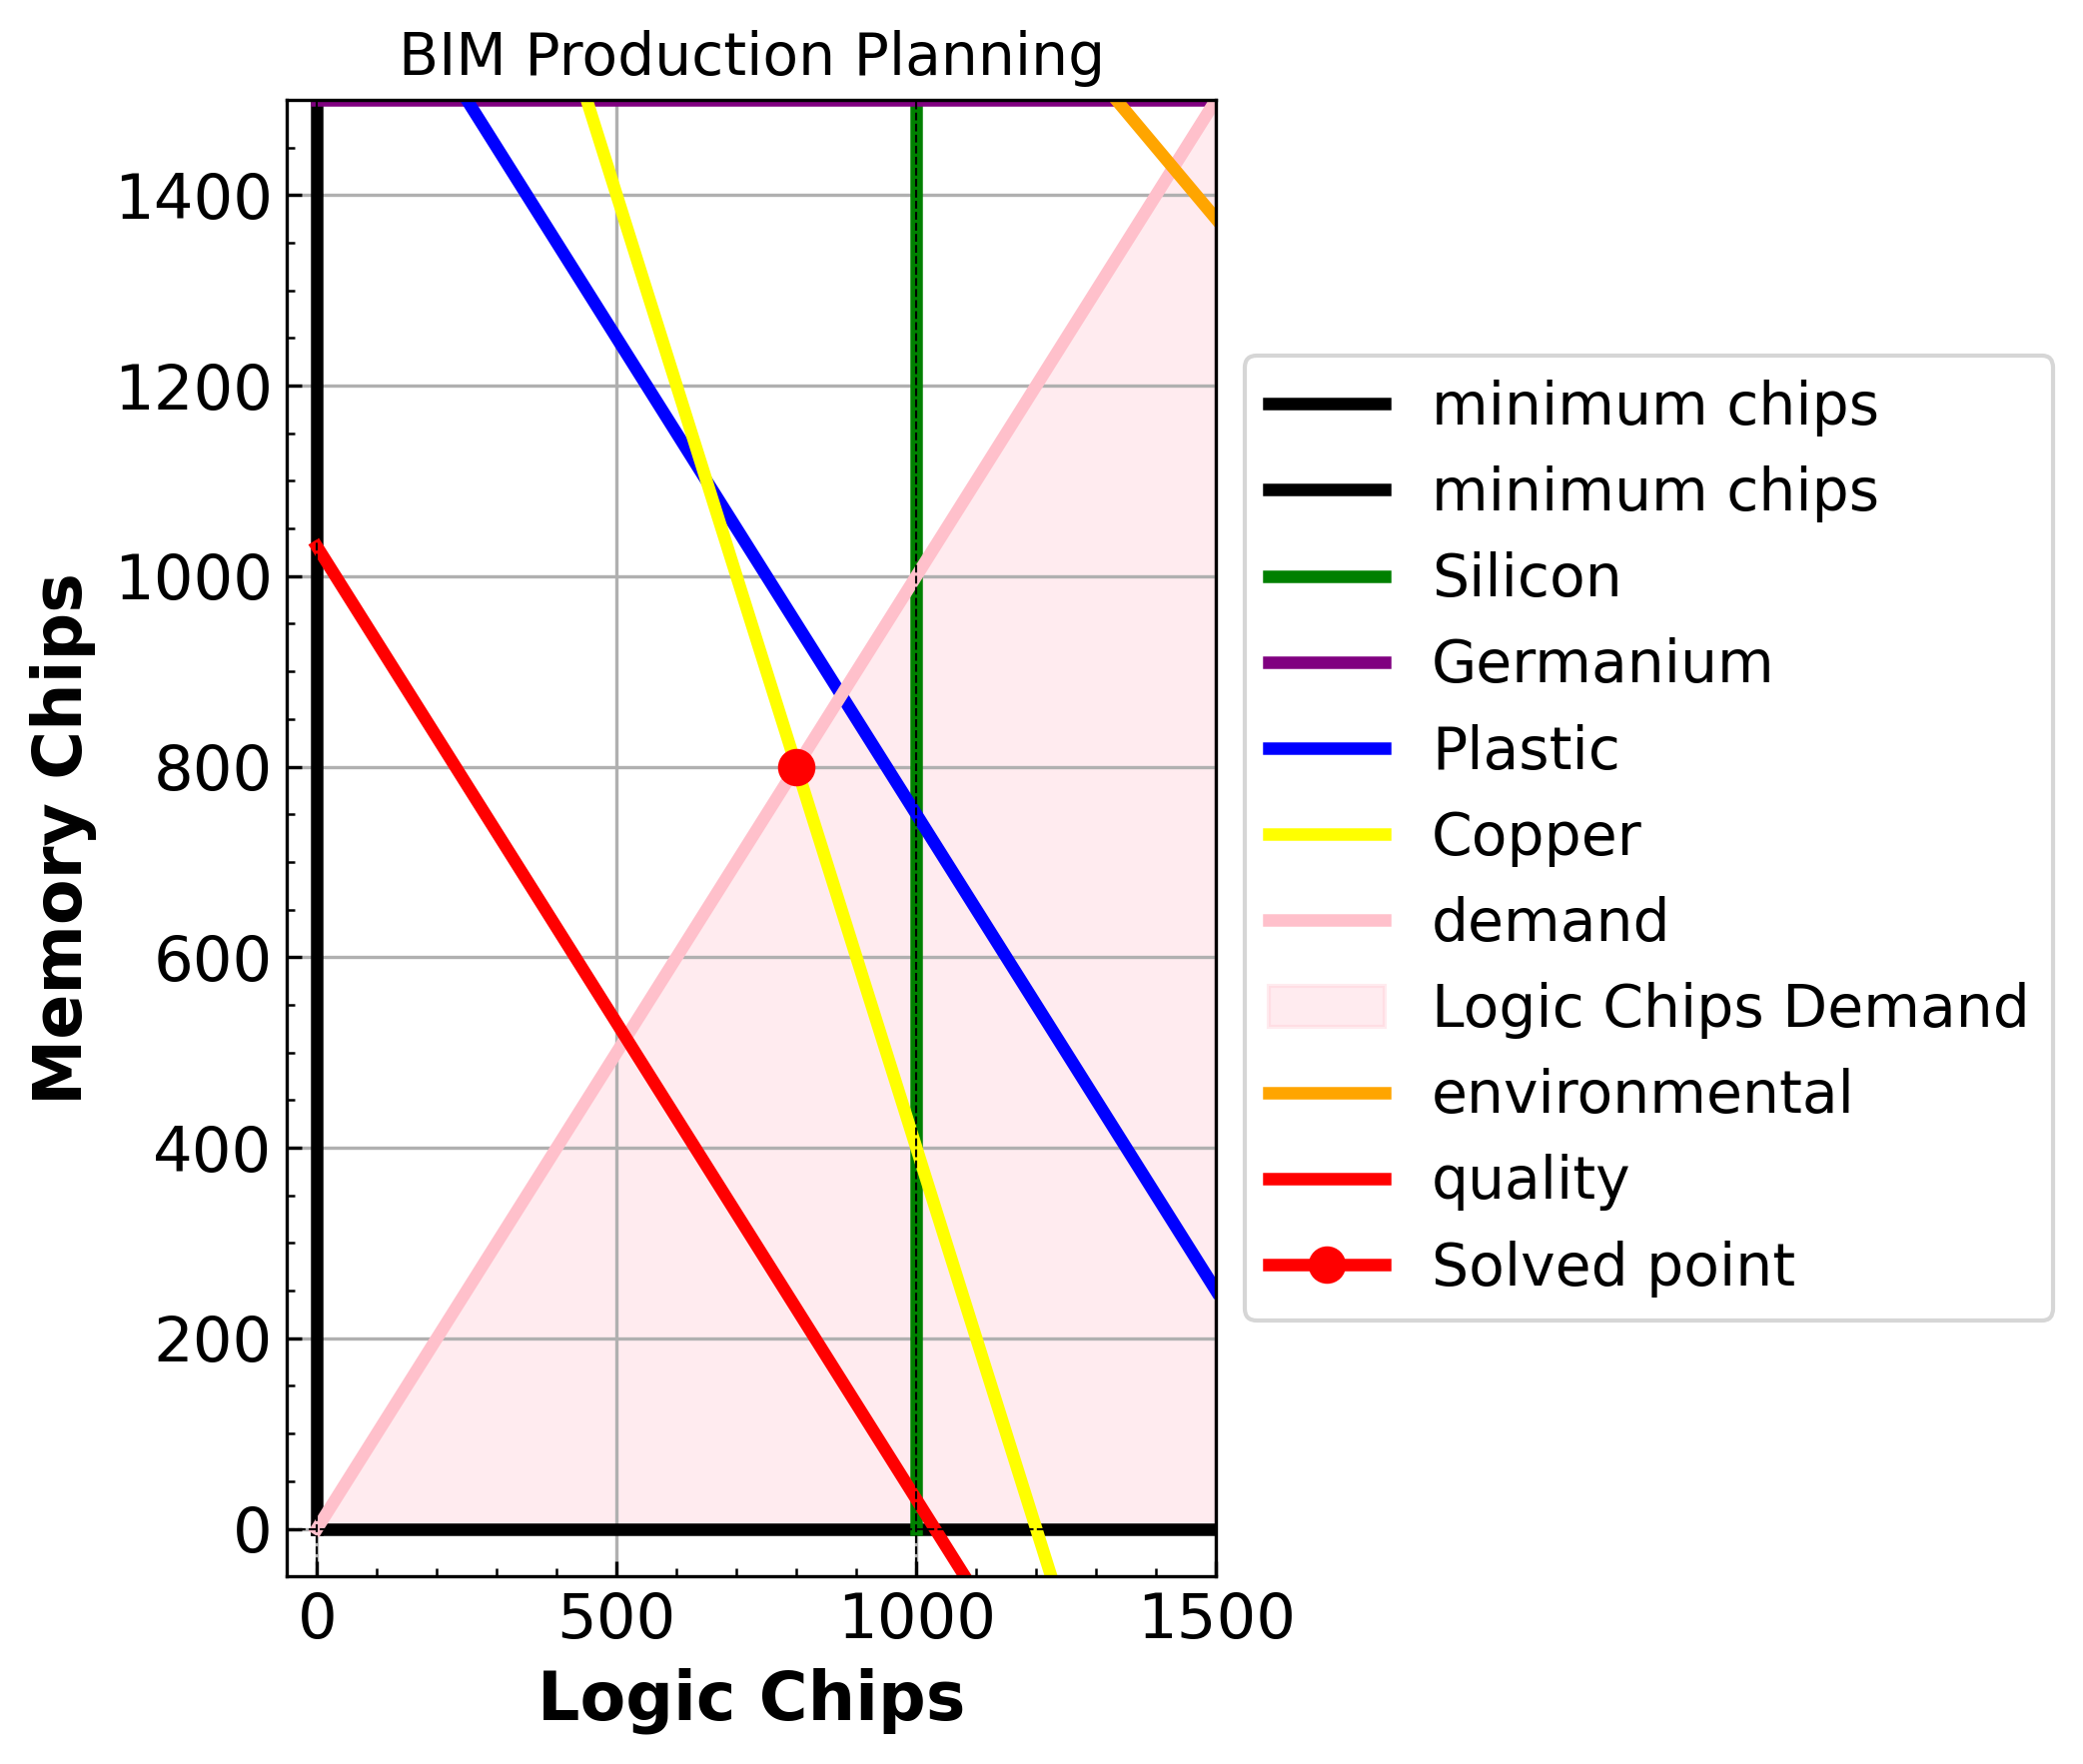

In [ ]:
m_vizualize(3,4,0.97,1)

In the base case, the optimal production plan yields 800 logic chips and 800 memory chips, resulting in a maximum profit of 16,800. This solution satisfies several constraints: environmental costs for logic and memory chips (3 and 4, respectively), demand favoring logic chips, and a quality requirement ensuring all produced chips are functional. The visual representation shows that the solution lies within the feasible region defined by these constraints, with the demand constraint ensuring that logic chip production is at least equal to memory chip production.

# Insights

# Sensitivity Analysis

In [ ]:
#from ipywidgets import interact
#interact(m_vizualize, env_x1=(1, 20, 1), env_x2 = (1,20, 1), defects = (0.57, 0.99, 0.01), demand = (0,1,1))

# Insights

**Environmental Constraint**

The constraint is inactive until both environmental cost values for
𝑥1 and x2 reach 6. This means that at lower values (less than 6), the environmental constraint is not binding, and the optimal solution is determined purely by other constraints (material limits, quality control, and demand). In terms of sensitivity analysis, before the environmental cost reaches 6, the system does not "feel" the impact of this constraint, as the optimal point remains in a region where this constraint is non-binding.
At higher environmental cost values, the system starts to restrict the feasible region more significantly, potentially leading to reduced profits or shifts in the balance of logic versus memory chip production to comply with the environmental threshold.

**Buyer Demand Constraint**

The demand constraint impacts the amoutn of total product we can create. It is more advategeous to create more memory chips as logic chips limits the total amount of supply we can make while still following all the constraints. Further, the demand constraint affects other constraints such as quality.

**Quality Constraint**

The system is highly sensitive to the quality control constraint, as seen in the change from 0.5 to 0.9. Increasing the quality chip threshold significantly shifts the feasible region, as shown by the movement of the orange line in the graphs. This alters the feasible solution space for chip production. From the movements in the quality constraint line, we learned that memory chips allow more defects than logic chips, offering greater flexibility when buyer demand shifts toward them. This offers the insight, combineed with the above buyer demand constraint, that when memory chips are more popular, this company will have higher profits.


